In [1]:
import torch
from data import get_datasets, get_test_loader
from utils import seed_everything

In [2]:
def test(test_dataloader, device, model):
    predict_score = 0
    num_samples = 0
    class_total = torch.zeros(10, dtype=torch.int32)
    class_wrong = torch.zeros(10, dtype=torch.int32)

    for (x, y) in test_dataloader:
        num_samples += y.size(0)
        x = x.to(device)

        output = model(x)
        output_idx = output.argmax(dim=1).cpu()

        sum_correct = (output_idx == y).sum().item()
        predict_score += sum_correct

        # 클래스별 오류 집계
        for i in range(10):
            class_total[i] += (y == i).sum().item()
            class_wrong[i] += ((output_idx != y) & (y == i)).sum().item()

    accuracy = predict_score / num_samples

    # 클래스별 오류율 계산
    class_error_rate = (class_wrong / class_total).numpy() * 100  # 백분율 변환

    return accuracy, class_error_rate

In [3]:
test_dataset, _, test_dataset_rotation = get_datasets("./data", train=False)
test_dataloader = get_test_loader(test_dataset, 256, 8)
test_dataloader_rotation = get_test_loader(test_dataset_rotation, 256, 8)

In [4]:
from model.linear import LinearModel

model = LinearModel(784, [500, 300, 100], 10)

In [5]:
model.load_state_dict(torch.load("/workspace/linear-and-classification/outputs/2025-02-13/16-53-50/best_model_dataset.pth"))

/tmp/ipykernel_15727/2535746210.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/workspace/linear-and-classification/outputs/2025-02-13

<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model.to(device)

LinearModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [8]:
accuracy, class_error_rate = test(test_dataloader, device, model)
accuracy_rotation, class_error_rate_rotation = test(test_dataloader_rotation, device, model)

In [9]:
print(f"class_error_rate: {class_error_rate}")
print(f"accuracy: {accuracy}")

class_error_rate: [ 2.3469388  1.9383259  9.496124   9.009901   6.211813  13.004485
  5.9498954  7.7821007 11.909651   9.712586 ]
accuracy: 0.9238


In [10]:
print(f"class_error_rate_rotation: {class_error_rate_rotation}")
print(f"accuracy_rotation: {accuracy_rotation}")

class_error_rate_rotation: [38.367348 69.95595  80.32946  77.128716 59.368633 76.4574   72.96451
 69.2607   68.172485 75.61942 ]
accuracy_rotation: 0.3119


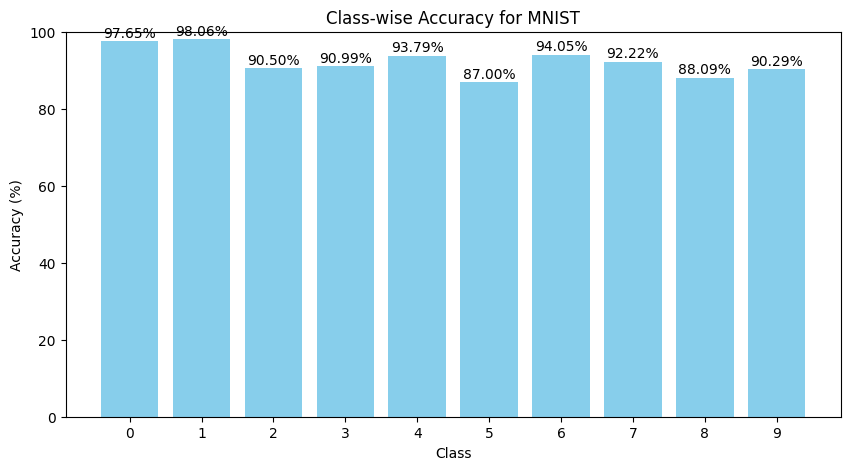

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스별 정확도 계산 (100 - 오류율)
class_accuracy = 100 - class_error_rate

# 클래스 레이블
classes = np.arange(10)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(classes, class_accuracy, color='skyblue')

# 그래프 설정
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy for MNIST")
plt.xticks(classes)
plt.ylim(0, 100)

# 정확도 값 표시
for i, acc in enumerate(class_accuracy):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)

plt.show()


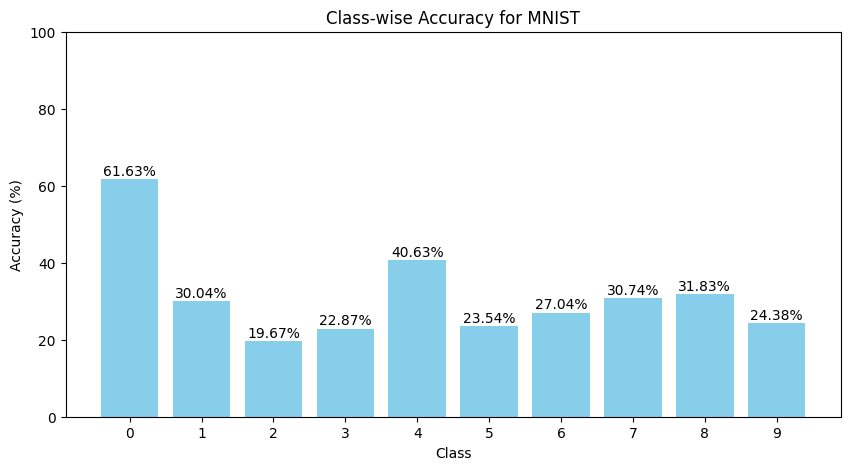

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스별 정확도 계산 (100 - 오류율)
class_accuracy = 100 - class_error_rate_rotation

# 클래스 레이블
classes = np.arange(10)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(classes, class_accuracy, color='skyblue')

# 그래프 설정
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy for MNIST")
plt.xticks(classes)
plt.ylim(0, 100)

# 정확도 값 표시
for i, acc in enumerate(class_accuracy):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)

plt.show()


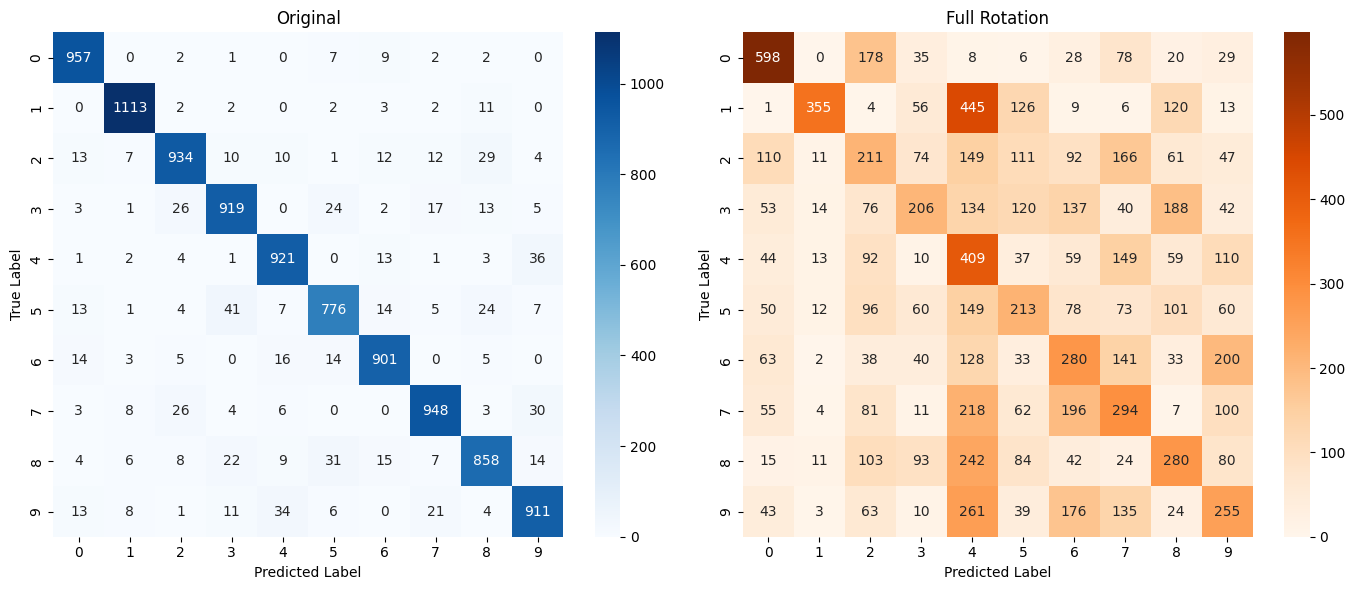

Confusion matrices saved to confusion_matrices.png


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_misclassification(model, test_dataloader, device="cpu"):
    """주어진 데이터로 혼동 행렬을 계산하는 함수"""
    num_classes = 10  # MNIST 클래스 개수
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y_true in test_dataloader:
            x = x.to(device)
            y_true = y_true.cpu().numpy()

            # 모델 예측
            output = model(x)
            y_pred = output.argmax(dim=1).cpu().numpy()

            # 혼동 행렬 업데이트
            for true, pred in zip(y_true, y_pred):
                confusion_matrix[true, pred] += 1

    return confusion_matrix

def plot_confusion_matrices(model, dataloader1, dataloader2, save_path="confusion_matrices.png", device="cpu"):
    """두 개의 데이터로부터 혼동 행렬을 계산하고, 나란히 비교하는 그래프를 저장하는 함수"""
    # 혼동 행렬 계산
    confusion_matrix1 = analyze_misclassification(model, dataloader1, device)
    confusion_matrix2 = analyze_misclassification(model, dataloader2, device)

    # 그래프 그리기
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(confusion_matrix1, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Original")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    sns.heatmap(confusion_matrix2, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
    axes[1].set_title("Full Rotation")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    print(f"Confusion matrices saved to {save_path}")

# 사용 예시
plot_confusion_matrices(model, test_dataloader, test_dataloader_rotation, save_path="confusion_matrices.png", device="cpu")